In [1]:
import pandas as pd
import numpy as np
import random as rnd
import time
import warnings
warnings.filterwarnings("ignore")

# visualization
import seaborn as sns
import matplotlib.pyplot as plt

# machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score,precision_score, recall_score, f1_score, classification_report, roc_curve, roc_auc_score

from sklearn import tree

from tqdm import tqdm

import plotly.graph_objs as go


In [2]:
df = pd.read_csv('C:\\Users\\Muhammad Hazim\\train.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
columns = df.columns.values

In [4]:
null_columns = []
null_total = []
null_percent = []

for column in columns:
    if df[column].isnull().any() == True:
        null_columns.append(column)
        null_total.append(df[column].isnull().sum())
        null_percent.append(df[column].isnull().sum()/df.shape[0]*100)

null_df = pd.DataFrame()
null_df['Features'] = null_columns
null_df['Total null values'] = null_total
null_df['Percentage(%)'] = null_percent

null_df.sort_values(by = 'Percentage(%)', ascending = False).round(2)

,Features,Total null values,Percentage(%)
1,Cabin,687,77.10
0,Age,177,19.87
2,Embarked,2,0.22


In [5]:
df = df.drop(['PassengerId','Name', 'Ticket','Cabin'], axis=1)

In [6]:
def plot_bar(column):
    table = pd.DataFrame()
    table['Survived'] = df[df['Survived'] == 1][column].value_counts()
    table['Not Survived'] = df[df['Survived'] == 0][column].value_counts()
    table.plot(kind = 'bar')
    plt.xlabel(f'{column}')
    plt.ylabel('Number of Clients')
    plt.title('Distribution of {} and survival'.format(column))
    plt.show()

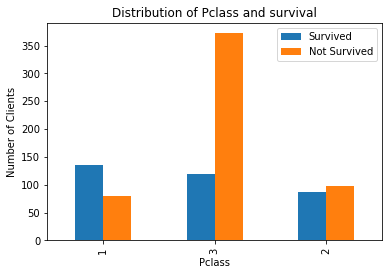

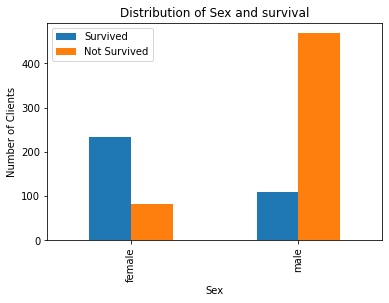

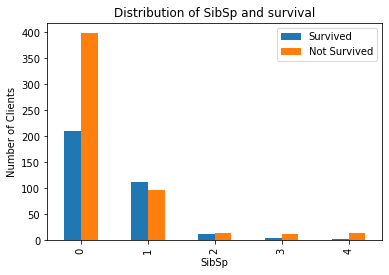

(None, None, None)

In [7]:
plot_bar('Pclass'),plot_bar('Sex'),plot_bar('SibSp')

In [8]:
df1 = df[['Pclass','Survived']].groupby(['Pclass'], as_index = False).mean().sort_values(by='Survived', ascending = False)
df2 = df[['Sex','Survived']].groupby(['Sex'], as_index = False).mean().sort_values(by='Survived', ascending = False)
df3 = df[['SibSp','Survived']].groupby(['SibSp'], as_index = False).mean().sort_values(by='Survived', ascending = False)

In [9]:
display(df1, df2, df3)

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


,Sex,Survived
0,female,0.742038
1,male,0.188908


,SibSp,Survived
1,1,0.535885
2,2,0.464286
0,0,0.345395
3,3,0.250000
4,4,0.166667
5,5,0.000000
6,8,0.000000


In [10]:
df['Sex'] = df['Sex'].map({'female': 1, 'male': 0})

In [11]:
guess_ages = np.zeros((2,3))
guess_ages

array([[0., 0., 0.],
       [0., 0., 0.]])

In [12]:
for i in range(0, 2):
    for j in range(0, 3):
        guess_df = df[(df['Sex'] == i) & \
                                  (df['Pclass'] == j+1)]['Age'].dropna()
        
        age_guess = guess_df.median()        
        guess_ages[i,j] = int( age_guess/0.5 + 0.5 ) * 0.5

In [13]:
for i in range(0, 2):
    for j in range(0, 3):
        guess_df = df[(df['Sex'] == i) & \
                                  (df['Pclass'] == j+1)]['Age'].dropna()

        # age_mean = guess_df.mean()
        # age_std = guess_df.std()
        # age_guess = rnd.uniform(age_mean - age_std, age_mean + age_std)

        age_guess = guess_df.median()

        # Convert random age float to nearest .5 age
        guess_ages[i,j] = int( age_guess/0.5 + 0.5 ) * 0.5
            
for i in range(0, 2):
    for j in range(0, 3):
        df.loc[ (df.Age.isnull()) & (df.Sex == i) & (df.Pclass == j+1),\
                'Age'] = guess_ages[i,j]

df['Age'] = df['Age'].astype(int)

df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,0,22,1,0,7.2500,S
1,1,1,1,38,1,0,71.2833,C
2,1,3,1,26,0,0,7.9250,S
3,1,1,1,35,1,0,53.1000,S
4,0,3,0,35,0,0,8.0500,S


In [14]:
df['AgeBand'] = pd.cut(df['Age'], 5)
df[['AgeBand', 'Survived']].groupby(['AgeBand'], as_index=False).mean().sort_values(by='AgeBand', ascending=True)

,AgeBand,Survived
0,"(-0.08, 16.0]",0.550000
1,"(16.0, 32.0]",0.337374
2,"(32.0, 48.0]",0.412037
3,"(48.0, 64.0]",0.434783
4,"(64.0, 80.0]",0.090909


In [15]:
df.loc[ df['Age'] <= 16, 'Age'] = 0
df.loc[(df['Age'] > 16) & (df['Age'] <= 32), 'Age'] = 1
df.loc[(df['Age'] > 32) & (df['Age'] <= 48), 'Age'] = 2
df.loc[(df['Age'] > 48) & (df['Age'] <= 64), 'Age'] = 3
df.loc[ df['Age'] > 64, 'Age'] = 4
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,AgeBand
0,0,3,0,1,1,0,7.2500,S,"(16.0, 32.0]"
1,1,1,1,2,1,0,71.2833,C,"(32.0, 48.0]"
2,1,3,1,1,0,0,7.9250,S,"(16.0, 32.0]"
3,1,1,1,2,1,0,53.1000,S,"(32.0, 48.0]"
4,0,3,0,2,0,0,8.0500,S,"(32.0, 48.0]"


In [16]:
df = df.drop(['AgeBand'], axis=1)

In [17]:
df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
df[['FamilySize', 'Survived']].groupby(['FamilySize'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,FamilySize,Survived
3,4,0.724138
2,3,0.578431
1,2,0.552795
6,7,0.333333
0,1,0.303538
4,5,0.200000
5,6,0.136364
7,8,0.000000
8,11,0.000000


In [18]:
df['IsNotAlone'] = 1
df.loc[df['FamilySize'] == 1, 'IsNotAlone'] = 0

df[['IsNotAlone', 'Survived']].groupby(['IsNotAlone'], as_index=False).mean()

,IsNotAlone,Survived
0,0,0.303538
1,1,0.505650


In [19]:
df = df.drop(['Parch', 'SibSp', 'FamilySize'], axis=1)
df.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,IsNotAlone
0,0,3,0,1,7.2500,S,1
1,1,1,1,2,71.2833,C,1
2,1,3,1,1,7.9250,S,0
3,1,1,1,2,53.1000,S,1
4,0,3,0,2,8.0500,S,0


In [20]:
df['Embarked'] = df['Embarked'].fillna(df.Embarked.dropna().mode()[0])
    
df[['Embarked', 'Survived']].groupby(['Embarked'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Embarked,Survived
0,C,0.553571
1,Q,0.389610
2,S,0.339009


In [21]:
df['FareBand'] = pd.qcut(df['Fare'], 4)
df[['FareBand', 'Survived']].groupby(['FareBand'], as_index=False).mean().sort_values(by='FareBand', ascending=True)

,FareBand,Survived
0,"(-0.001, 7.91]",0.197309
1,"(7.91, 14.454]",0.303571
2,"(14.454, 31.0]",0.454955
3,"(31.0, 512.329]",0.581081


In [22]:
df.loc[ df['Fare'] <= 7.91, 'Fare'] = 0
df.loc[(df['Fare'] > 7.91) & (df['Fare'] <= 14.454), 'Fare'] = 1
df.loc[(df['Fare'] > 14.454) & (df['Fare'] <= 31), 'Fare']   = 2
df.loc[ df['Fare'] > 31, 'Fare'] = 3
df['Fare'] =df['Fare'].astype('int')  
df.head(10)

,Survived,Pclass,Sex,Age,Fare,Embarked,IsNotAlone,FareBand
0,0,3,0,1,0,S,1,"(-0.001, 7.91]"
1,1,1,1,2,3,C,1,"(31.0, 512.329]"
2,1,3,1,1,1,S,0,"(7.91, 14.454]"
3,1,1,1,2,3,S,1,"(31.0, 512.329]"
4,0,3,0,2,1,S,0,"(7.91, 14.454]"
5,0,3,0,1,1,Q,0,"(7.91, 14.454]"
6,0,1,0,3,3,S,0,"(31.0, 512.329]"
7,0,3,0,0,2,S,1,"(14.454, 31.0]"
8,1,3,1,1,1,S,1,"(7.91, 14.454]"
9,1,2,1,0,2,C,1,"(14.454, 31.0]"


In [23]:
df = df.drop('FareBand', axis=1)

In [24]:
data = pd.get_dummies(df, drop_first = True)

In [25]:
x = data.drop("Survived", axis=1)
y = data["Survived"]

In [26]:
random_state = 42

In [27]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42, stratify = y)

## Logistic Regression

In [42]:
lr = LogisticRegression()
lr.fit(x_train, y_train)

LogisticRegression()

In [43]:
df1 = pd.DataFrame(index = ['Accuracy', 'Precision', 'ROC AUC'] )
df1['Train Score'] = [accuracy_score(y_train, lr.predict(x_train)), precision_score(y_train, lr.predict(x_train)), roc_auc_score(y_train, lr.predict_proba(x_train)[:,1])]
df1['Test Score'] = [accuracy_score(y_test, lr.predict(x_test)), precision_score(y_test, lr.predict(x_test)), roc_auc_score(y_test, lr.predict_proba(x_test)[:,1])]        
df1

,Train Score,Test Score
Accuracy,0.794944,0.776536
Precision,0.737828,0.710145
ROC AUC,0.859959,0.824967


## Decision Tree Classifier

In [58]:
dt = DecisionTreeClassifier(max_depth = 10)
dt.fit(x_train, y_train)

DecisionTreeClassifier(max_depth=10)

In [59]:
df1 = pd.DataFrame(index = ['Accuracy', 'Precision', 'ROC AUC'] )
df1['Train Score'] = [accuracy_score(y_train, dt.predict(x_train)), precision_score(y_train, dt.predict(x_train)), roc_auc_score(y_train, dt.predict_proba(x_train)[:,1])]
df1['Test Score'] = [accuracy_score(y_test, dt.predict(x_test)), precision_score(y_test, dt.predict(x_test)), roc_auc_score(y_test, dt.predict_proba(x_test)[:,1])]        
df1

,Train Score,Test Score
Accuracy,0.863764,0.793296
Precision,0.872881,0.775862
ROC AUC,0.934813,0.827536


[Text(538.2213541666667, 1037.7818181818182, 'X[1] <= 0.5\ngini = 0.473\nsamples = 712\nvalue = [439, 273]'),
 Text(259.4635416666667, 938.9454545454546, 'X[0] <= 1.5\ngini = 0.302\nsamples = 459\nvalue = [374, 85]'),
 Text(112.375, 840.1090909090909, 'X[3] <= 1.0\ngini = 0.466\nsamples = 92\nvalue = [58, 34]'),
 Text(102.04166666666667, 741.2727272727273, 'gini = 0.0\nsamples = 6\nvalue = [6, 0]'),
 Text(122.70833333333334, 741.2727272727273, 'X[2] <= 0.5\ngini = 0.478\nsamples = 86\nvalue = [52, 34]'),
 Text(112.375, 642.4363636363637, 'gini = 0.0\nsamples = 2\nvalue = [0, 2]'),
 Text(133.04166666666669, 642.4363636363637, 'X[3] <= 2.5\ngini = 0.472\nsamples = 84\nvalue = [52, 32]'),
 Text(72.33333333333334, 543.6, 'X[2] <= 2.5\ngini = 0.5\nsamples = 34\nvalue = [17, 17]'),
 Text(51.66666666666667, 444.76363636363635, 'X[4] <= 0.5\ngini = 0.493\nsamples = 25\nvalue = [11, 14]'),
 Text(41.333333333333336, 345.9272727272727, 'X[2] <= 1.5\ngini = 0.486\nsamples = 24\nvalue = [10, 14]'),

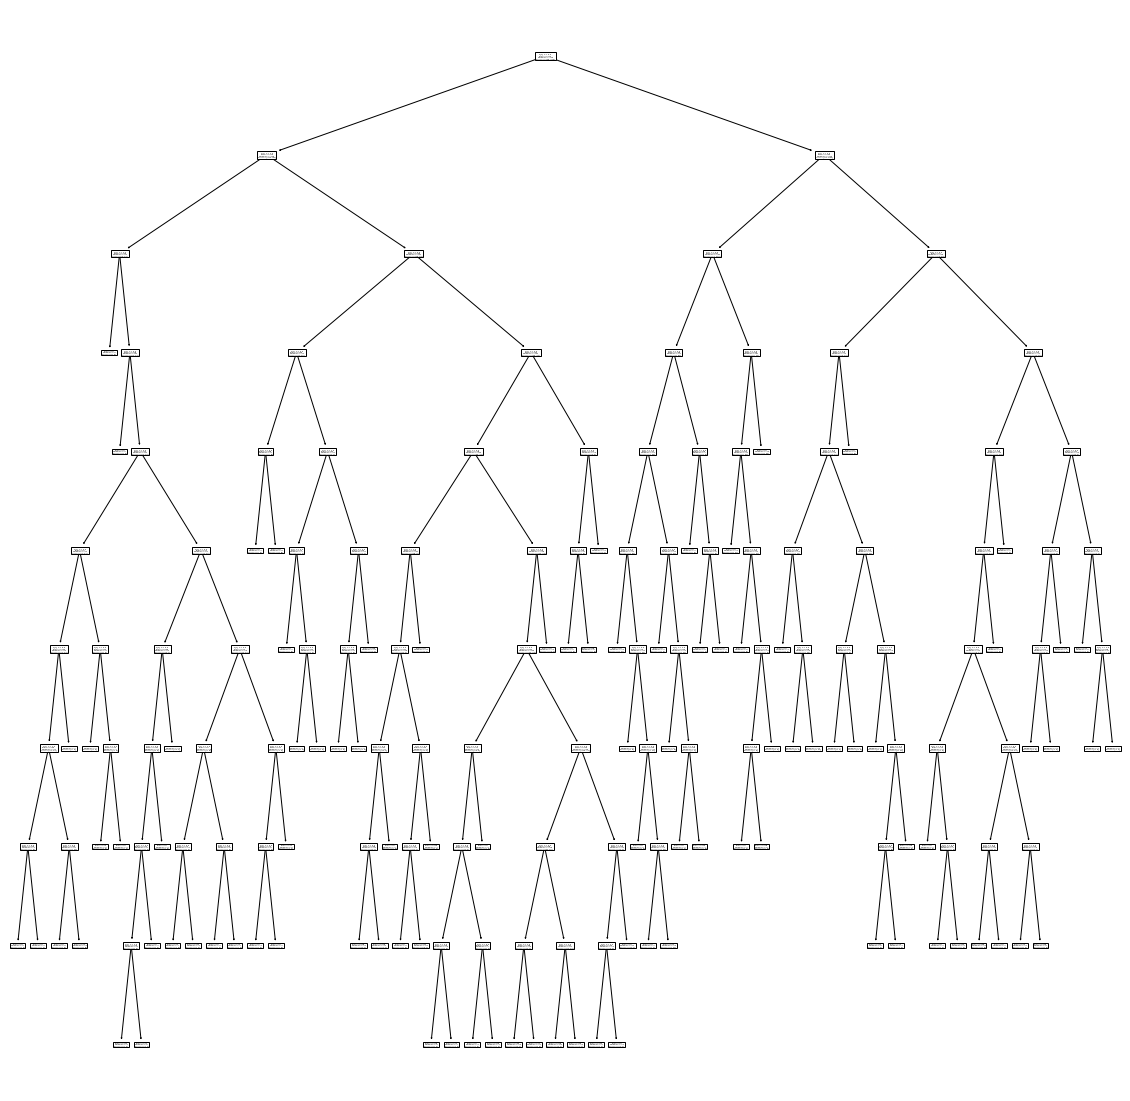

In [98]:
plt.figure(figsize = (20,20))
tree.plot_tree(dt)

## Random Forest Classifier

In [67]:
rf = RandomForestClassifier(max_depth=5)
rf.fit(x_train, y_train)

RandomForestClassifier(max_depth=5)

In [68]:
df1 = pd.DataFrame(index = ['Accuracy', 'Precision', 'ROC AUC'] )
df1['Train Score'] = [accuracy_score(y_train, rf.predict(x_train)), precision_score(y_train, rf.predict(x_train)), roc_auc_score(y_train, rf.predict_proba(x_train)[:,1])]
df1['Test Score'] = [accuracy_score(y_test, rf.predict(x_test)), precision_score(y_test, rf.predict(x_test)), roc_auc_score(y_test, rf.predict_proba(x_test)[:,1])]        
df1

,Train Score,Test Score
Accuracy,0.838483,0.804469
Precision,0.907216,0.869565
ROC AUC,0.896839,0.837615


## Cat Boost Classifier

In [84]:
cb = CatBoostClassifier(learning_rate = 0.001)
cb.fit(x_train, y_train)

0:	learn: 0.6924126	total: 3.58ms	remaining: 3.57s
1:	learn: 0.6917337	total: 5.39ms	remaining: 2.69s
2:	learn: 0.6910390	total: 7.97ms	remaining: 2.65s
3:	learn: 0.6903021	total: 11.3ms	remaining: 2.8s
4:	learn: 0.6896543	total: 13.8ms	remaining: 2.74s
5:	learn: 0.6889274	total: 16.4ms	remaining: 2.72s
6:	learn: 0.6882362	total: 18.1ms	remaining: 2.57s
7:	learn: 0.6877169	total: 19.8ms	remaining: 2.45s
8:	learn: 0.6870780	total: 21.7ms	remaining: 2.39s
9:	learn: 0.6863450	total: 23.4ms	remaining: 2.32s
10:	learn: 0.6856607	total: 25.2ms	remaining: 2.27s
11:	learn: 0.6850024	total: 26.8ms	remaining: 2.21s
12:	learn: 0.6842523	total: 28.6ms	remaining: 2.17s
13:	learn: 0.6836297	total: 30.1ms	remaining: 2.12s
14:	learn: 0.6830606	total: 31.6ms	remaining: 2.08s
15:	learn: 0.6823759	total: 33.4ms	remaining: 2.06s
16:	learn: 0.6816746	total: 35.8ms	remaining: 2.07s
17:	learn: 0.6810130	total: 37.7ms	remaining: 2.06s
18:	learn: 0.6803399	total: 40.1ms	remaining: 2.07s
19:	learn: 0.6797472	to

167:	learn: 0.6002337	total: 317ms	remaining: 1.57s
168:	learn: 0.5997688	total: 319ms	remaining: 1.57s
169:	learn: 0.5993118	total: 321ms	remaining: 1.57s
170:	learn: 0.5987954	total: 323ms	remaining: 1.56s
171:	learn: 0.5983190	total: 325ms	remaining: 1.56s
172:	learn: 0.5978022	total: 326ms	remaining: 1.56s
173:	learn: 0.5973203	total: 328ms	remaining: 1.56s
174:	learn: 0.5968107	total: 330ms	remaining: 1.56s
175:	learn: 0.5963841	total: 333ms	remaining: 1.56s
176:	learn: 0.5959087	total: 334ms	remaining: 1.55s
177:	learn: 0.5954576	total: 336ms	remaining: 1.55s
178:	learn: 0.5949391	total: 338ms	remaining: 1.55s
179:	learn: 0.5945012	total: 339ms	remaining: 1.55s
180:	learn: 0.5939973	total: 341ms	remaining: 1.54s
181:	learn: 0.5935086	total: 343ms	remaining: 1.54s
182:	learn: 0.5930698	total: 345ms	remaining: 1.54s
183:	learn: 0.5926522	total: 347ms	remaining: 1.54s
184:	learn: 0.5921980	total: 350ms	remaining: 1.54s
185:	learn: 0.5917367	total: 352ms	remaining: 1.54s
186:	learn: 

331:	learn: 0.5373325	total: 631ms	remaining: 1.27s
332:	learn: 0.5370797	total: 633ms	remaining: 1.27s
333:	learn: 0.5367432	total: 636ms	remaining: 1.27s
334:	learn: 0.5363900	total: 639ms	remaining: 1.27s
335:	learn: 0.5361047	total: 640ms	remaining: 1.26s
336:	learn: 0.5357693	total: 642ms	remaining: 1.26s
337:	learn: 0.5354692	total: 645ms	remaining: 1.26s
338:	learn: 0.5351541	total: 647ms	remaining: 1.26s
339:	learn: 0.5348464	total: 649ms	remaining: 1.26s
340:	learn: 0.5345109	total: 651ms	remaining: 1.26s
341:	learn: 0.5341533	total: 654ms	remaining: 1.26s
342:	learn: 0.5339923	total: 657ms	remaining: 1.26s
343:	learn: 0.5336694	total: 659ms	remaining: 1.26s
344:	learn: 0.5334027	total: 661ms	remaining: 1.25s
345:	learn: 0.5330719	total: 663ms	remaining: 1.25s
346:	learn: 0.5327414	total: 665ms	remaining: 1.25s
347:	learn: 0.5323782	total: 667ms	remaining: 1.25s
348:	learn: 0.5320556	total: 669ms	remaining: 1.25s
349:	learn: 0.5317982	total: 671ms	remaining: 1.25s
350:	learn: 

535:	learn: 0.4866029	total: 1.23s	remaining: 1.07s
536:	learn: 0.4863852	total: 1.24s	remaining: 1.07s
537:	learn: 0.4861604	total: 1.24s	remaining: 1.06s
538:	learn: 0.4860513	total: 1.24s	remaining: 1.06s
539:	learn: 0.4858676	total: 1.24s	remaining: 1.06s
540:	learn: 0.4856493	total: 1.25s	remaining: 1.06s
541:	learn: 0.4853936	total: 1.25s	remaining: 1.06s
542:	learn: 0.4852378	total: 1.25s	remaining: 1.05s
543:	learn: 0.4849850	total: 1.25s	remaining: 1.05s
544:	learn: 0.4848893	total: 1.26s	remaining: 1.05s
545:	learn: 0.4846496	total: 1.26s	remaining: 1.05s
546:	learn: 0.4844233	total: 1.26s	remaining: 1.04s
547:	learn: 0.4843282	total: 1.26s	remaining: 1.04s
548:	learn: 0.4841745	total: 1.26s	remaining: 1.04s
549:	learn: 0.4839360	total: 1.27s	remaining: 1.04s
550:	learn: 0.4836879	total: 1.27s	remaining: 1.03s
551:	learn: 0.4835158	total: 1.27s	remaining: 1.03s
552:	learn: 0.4833189	total: 1.27s	remaining: 1.03s
553:	learn: 0.4830834	total: 1.28s	remaining: 1.03s
554:	learn: 

771:	learn: 0.4479293	total: 1.7s	remaining: 501ms
772:	learn: 0.4477544	total: 1.7s	remaining: 499ms
773:	learn: 0.4476534	total: 1.7s	remaining: 497ms
774:	learn: 0.4475093	total: 1.7s	remaining: 494ms
775:	learn: 0.4474176	total: 1.7s	remaining: 492ms
776:	learn: 0.4472819	total: 1.71s	remaining: 490ms
777:	learn: 0.4471609	total: 1.71s	remaining: 487ms
778:	learn: 0.4470576	total: 1.71s	remaining: 485ms
779:	learn: 0.4469155	total: 1.71s	remaining: 483ms
780:	learn: 0.4468048	total: 1.71s	remaining: 480ms
781:	learn: 0.4466418	total: 1.72s	remaining: 478ms
782:	learn: 0.4465262	total: 1.72s	remaining: 476ms
783:	learn: 0.4463566	total: 1.72s	remaining: 474ms
784:	learn: 0.4462465	total: 1.72s	remaining: 472ms
785:	learn: 0.4461125	total: 1.73s	remaining: 470ms
786:	learn: 0.4460307	total: 1.73s	remaining: 468ms
787:	learn: 0.4459192	total: 1.73s	remaining: 466ms
788:	learn: 0.4458062	total: 1.73s	remaining: 463ms
789:	learn: 0.4456835	total: 1.74s	remaining: 461ms
790:	learn: 0.445

981:	learn: 0.4255578	total: 2.16s	remaining: 39.6ms
982:	learn: 0.4254409	total: 2.16s	remaining: 37.4ms
983:	learn: 0.4253554	total: 2.16s	remaining: 35.2ms
984:	learn: 0.4252632	total: 2.17s	remaining: 33ms
985:	learn: 0.4251516	total: 2.17s	remaining: 30.8ms
986:	learn: 0.4250556	total: 2.17s	remaining: 28.6ms
987:	learn: 0.4250161	total: 2.17s	remaining: 26.4ms
988:	learn: 0.4249089	total: 2.18s	remaining: 24.2ms
989:	learn: 0.4248025	total: 2.18s	remaining: 22ms
990:	learn: 0.4247375	total: 2.18s	remaining: 19.8ms
991:	learn: 0.4246533	total: 2.18s	remaining: 17.6ms
992:	learn: 0.4245787	total: 2.19s	remaining: 15.4ms
993:	learn: 0.4244730	total: 2.19s	remaining: 13.2ms
994:	learn: 0.4243834	total: 2.19s	remaining: 11ms
995:	learn: 0.4242777	total: 2.19s	remaining: 8.81ms
996:	learn: 0.4241574	total: 2.19s	remaining: 6.61ms
997:	learn: 0.4240947	total: 2.2s	remaining: 4.4ms
998:	learn: 0.4240385	total: 2.2s	remaining: 2.2ms
999:	learn: 0.4239333	total: 2.2s	remaining: 0us


In [85]:
df1 = pd.DataFrame(index = ['Accuracy', 'Precision', 'ROC AUC'] )
df1['Train Score'] = [accuracy_score(y_train, cb.predict(x_train)), precision_score(y_train, cb.predict(x_train)), roc_auc_score(y_train, cb.predict_proba(x_train)[:,1])]
df1['Test Score'] = [accuracy_score(y_test, cb.predict(x_test)), precision_score(y_test, cb.predict(x_test)), roc_auc_score(y_test, cb.predict_proba(x_test)[:,1])]        
df1

,Train Score,Test Score
Accuracy,0.838483,0.815642
Precision,0.895000,0.891304
ROC AUC,0.895254,0.833794


##  ROC Curve of all models

In [91]:
classifiers = [lr, dt, rf, cb]

result_table = pd.DataFrame(columns=['classifiers', 'fpr','tpr','auc'])


for cls in classifiers:
    model = cls.fit(x_train, y_train)
    yproba = model.predict_proba(x_test)[:,1]
    
    fpr, tpr, _ = roc_curve(y_test,  yproba)
    auc = roc_auc_score(y_test, yproba)
    
    result_table = result_table.append({'classifiers':cls.__class__.__name__,
                                        'fpr':fpr, 
                                        'tpr':tpr, 
                                        'auc':auc}, ignore_index=True)

result_table.set_index('classifiers', inplace=True)

0:	learn: 0.6924126	total: 6.09ms	remaining: 6.08s
1:	learn: 0.6917337	total: 8.74ms	remaining: 4.36s
2:	learn: 0.6910390	total: 11.2ms	remaining: 3.71s
3:	learn: 0.6903021	total: 13.9ms	remaining: 3.46s
4:	learn: 0.6896543	total: 16.4ms	remaining: 3.25s
5:	learn: 0.6889274	total: 19ms	remaining: 3.15s
6:	learn: 0.6882362	total: 21.5ms	remaining: 3.06s
7:	learn: 0.6877169	total: 23.8ms	remaining: 2.95s
8:	learn: 0.6870780	total: 26.8ms	remaining: 2.95s
9:	learn: 0.6863450	total: 31.9ms	remaining: 3.15s
10:	learn: 0.6856607	total: 36.9ms	remaining: 3.31s
11:	learn: 0.6850024	total: 41.3ms	remaining: 3.4s
12:	learn: 0.6842523	total: 46.3ms	remaining: 3.52s
13:	learn: 0.6836297	total: 51.1ms	remaining: 3.6s
14:	learn: 0.6830606	total: 53.5ms	remaining: 3.51s
15:	learn: 0.6823759	total: 56.2ms	remaining: 3.46s
16:	learn: 0.6816746	total: 58.8ms	remaining: 3.4s
17:	learn: 0.6810130	total: 61.3ms	remaining: 3.34s
18:	learn: 0.6803399	total: 63.8ms	remaining: 3.29s
19:	learn: 0.6797472	total:

217:	learn: 0.5785537	total: 608ms	remaining: 2.18s
218:	learn: 0.5781091	total: 610ms	remaining: 2.17s
219:	learn: 0.5776271	total: 612ms	remaining: 2.17s
220:	learn: 0.5772823	total: 614ms	remaining: 2.16s
221:	learn: 0.5768677	total: 617ms	remaining: 2.16s
222:	learn: 0.5764650	total: 619ms	remaining: 2.16s
223:	learn: 0.5760125	total: 621ms	remaining: 2.15s
224:	learn: 0.5755926	total: 624ms	remaining: 2.15s
225:	learn: 0.5751708	total: 627ms	remaining: 2.15s
226:	learn: 0.5746936	total: 630ms	remaining: 2.14s
227:	learn: 0.5743770	total: 632ms	remaining: 2.14s
228:	learn: 0.5739925	total: 635ms	remaining: 2.14s
229:	learn: 0.5737765	total: 636ms	remaining: 2.13s
230:	learn: 0.5733496	total: 639ms	remaining: 2.13s
231:	learn: 0.5729762	total: 641ms	remaining: 2.12s
232:	learn: 0.5725557	total: 643ms	remaining: 2.12s
233:	learn: 0.5721258	total: 646ms	remaining: 2.11s
234:	learn: 0.5717620	total: 648ms	remaining: 2.11s
235:	learn: 0.5712936	total: 650ms	remaining: 2.1s
236:	learn: 0

384:	learn: 0.5215709	total: 929ms	remaining: 1.48s
385:	learn: 0.5213301	total: 931ms	remaining: 1.48s
386:	learn: 0.5210708	total: 933ms	remaining: 1.48s
387:	learn: 0.5208226	total: 934ms	remaining: 1.47s
388:	learn: 0.5205189	total: 936ms	remaining: 1.47s
389:	learn: 0.5203313	total: 938ms	remaining: 1.47s
390:	learn: 0.5199823	total: 939ms	remaining: 1.46s
391:	learn: 0.5196988	total: 941ms	remaining: 1.46s
392:	learn: 0.5193770	total: 943ms	remaining: 1.46s
393:	learn: 0.5190932	total: 945ms	remaining: 1.45s
394:	learn: 0.5187731	total: 947ms	remaining: 1.45s
395:	learn: 0.5185262	total: 948ms	remaining: 1.45s
396:	learn: 0.5182536	total: 951ms	remaining: 1.44s
397:	learn: 0.5181140	total: 952ms	remaining: 1.44s
398:	learn: 0.5178728	total: 954ms	remaining: 1.44s
399:	learn: 0.5176302	total: 956ms	remaining: 1.43s
400:	learn: 0.5173129	total: 958ms	remaining: 1.43s
401:	learn: 0.5170813	total: 959ms	remaining: 1.43s
402:	learn: 0.5168238	total: 961ms	remaining: 1.42s
403:	learn: 

563:	learn: 0.4812596	total: 1.25s	remaining: 968ms
564:	learn: 0.4810680	total: 1.25s	remaining: 966ms
565:	learn: 0.4808369	total: 1.26s	remaining: 963ms
566:	learn: 0.4806034	total: 1.26s	remaining: 961ms
567:	learn: 0.4803510	total: 1.26s	remaining: 958ms
568:	learn: 0.4801232	total: 1.26s	remaining: 956ms
569:	learn: 0.4799397	total: 1.26s	remaining: 953ms
570:	learn: 0.4797512	total: 1.26s	remaining: 951ms
571:	learn: 0.4795694	total: 1.27s	remaining: 948ms
572:	learn: 0.4793383	total: 1.27s	remaining: 946ms
573:	learn: 0.4791003	total: 1.27s	remaining: 943ms
574:	learn: 0.4789347	total: 1.27s	remaining: 940ms
575:	learn: 0.4787199	total: 1.27s	remaining: 938ms
576:	learn: 0.4785055	total: 1.28s	remaining: 936ms
577:	learn: 0.4782879	total: 1.28s	remaining: 934ms
578:	learn: 0.4780869	total: 1.28s	remaining: 932ms
579:	learn: 0.4779222	total: 1.28s	remaining: 929ms
580:	learn: 0.4777340	total: 1.28s	remaining: 926ms
581:	learn: 0.4775109	total: 1.29s	remaining: 924ms
582:	learn: 

735:	learn: 0.4529764	total: 1.57s	remaining: 565ms
736:	learn: 0.4527925	total: 1.58s	remaining: 563ms
737:	learn: 0.4526217	total: 1.58s	remaining: 561ms
738:	learn: 0.4524744	total: 1.58s	remaining: 559ms
739:	learn: 0.4523226	total: 1.58s	remaining: 556ms
740:	learn: 0.4521563	total: 1.58s	remaining: 554ms
741:	learn: 0.4520981	total: 1.59s	remaining: 552ms
742:	learn: 0.4519504	total: 1.59s	remaining: 549ms
743:	learn: 0.4517934	total: 1.59s	remaining: 547ms
744:	learn: 0.4516426	total: 1.59s	remaining: 545ms
745:	learn: 0.4514951	total: 1.59s	remaining: 543ms
746:	learn: 0.4513151	total: 1.59s	remaining: 540ms
747:	learn: 0.4511871	total: 1.6s	remaining: 538ms
748:	learn: 0.4510900	total: 1.6s	remaining: 536ms
749:	learn: 0.4509412	total: 1.6s	remaining: 534ms
750:	learn: 0.4507987	total: 1.6s	remaining: 532ms
751:	learn: 0.4506509	total: 1.61s	remaining: 530ms
752:	learn: 0.4505650	total: 1.61s	remaining: 527ms
753:	learn: 0.4503959	total: 1.61s	remaining: 525ms
754:	learn: 0.45

912:	learn: 0.4322674	total: 1.9s	remaining: 181ms
913:	learn: 0.4321519	total: 1.91s	remaining: 179ms
914:	learn: 0.4320385	total: 1.91s	remaining: 177ms
915:	learn: 0.4319293	total: 1.91s	remaining: 175ms
916:	learn: 0.4318085	total: 1.91s	remaining: 173ms
917:	learn: 0.4317197	total: 1.91s	remaining: 171ms
918:	learn: 0.4316089	total: 1.91s	remaining: 169ms
919:	learn: 0.4314832	total: 1.92s	remaining: 167ms
920:	learn: 0.4313598	total: 1.92s	remaining: 165ms
921:	learn: 0.4312695	total: 1.92s	remaining: 162ms
922:	learn: 0.4311670	total: 1.92s	remaining: 160ms
923:	learn: 0.4310750	total: 1.92s	remaining: 158ms
924:	learn: 0.4309466	total: 1.93s	remaining: 156ms
925:	learn: 0.4308235	total: 1.93s	remaining: 154ms
926:	learn: 0.4306833	total: 1.93s	remaining: 152ms
927:	learn: 0.4305785	total: 1.93s	remaining: 150ms
928:	learn: 0.4305368	total: 1.93s	remaining: 148ms
929:	learn: 0.4304314	total: 1.94s	remaining: 146ms
930:	learn: 0.4303163	total: 1.94s	remaining: 144ms
931:	learn: 0

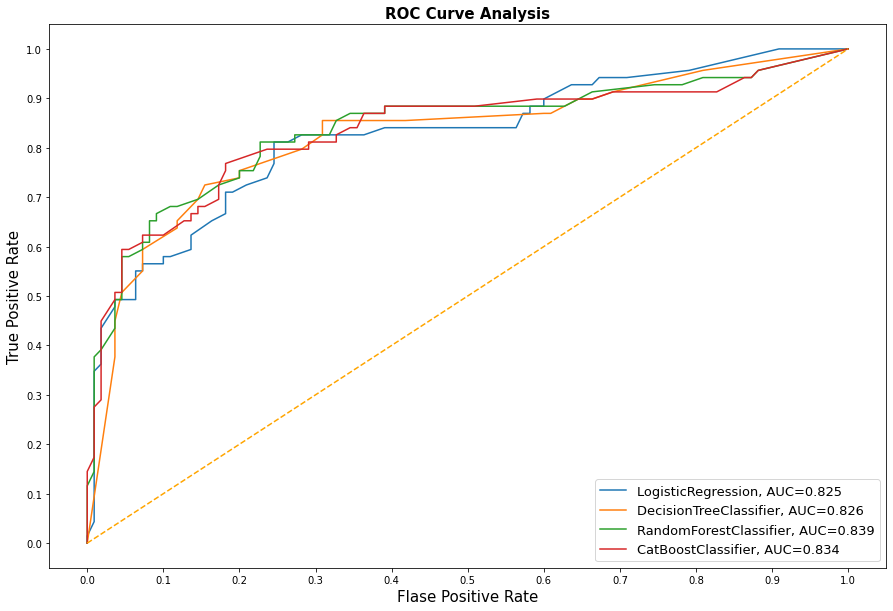

In [92]:
fig = plt.figure(figsize=(15,10))

for i in result_table.index:
    plt.plot(result_table.loc[i]['fpr'], 
             result_table.loc[i]['tpr'], 
             label="{}, AUC={:.3f}".format(i, result_table.loc[i]['auc']))
    
plt.plot([0,1], [0,1], color='orange', linestyle='--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("Flase Positive Rate", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=15)

plt.title('ROC Curve Analysis', fontweight='bold', fontsize=15)
plt.legend(prop={'size':13}, loc='lower right')

plt.show()

## Feature Importance of Random Forest Classifer

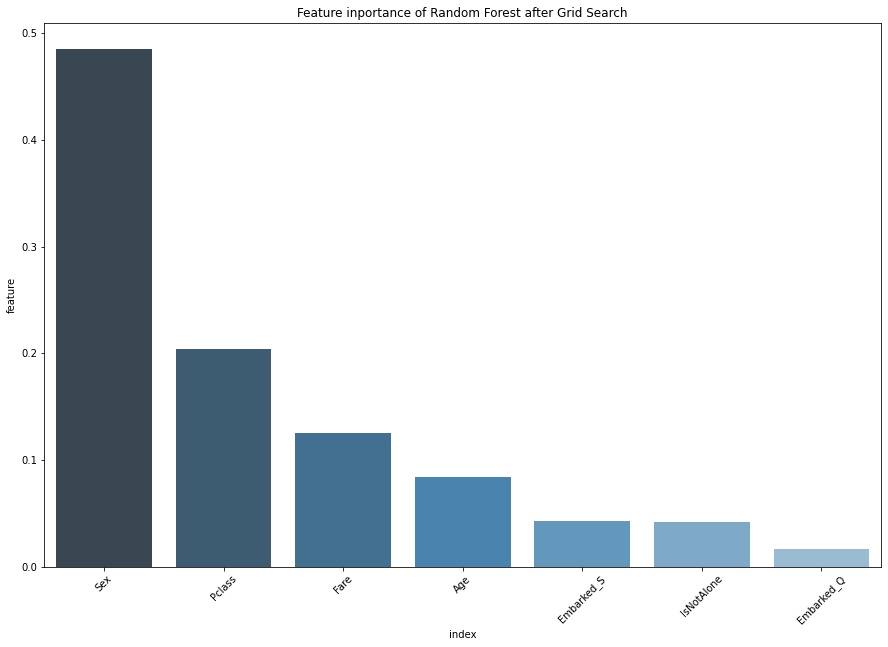

In [96]:
def build_feature_importance(model, X_train, y_train):
    
    models = RandomForestClassifier(max_depth = 5)
    models.fit(x_train, y_train)
    data = pd.DataFrame(models.feature_importances_, x_train.columns, columns=["feature"])
    data = data.sort_values(by='feature', ascending=False).reset_index()
    plt.figure(figsize=(15,10))
    sns.barplot(x='index', y='feature', data=data[:10], palette="Blues_d")
    plt.title('Feature inportance of Random Forest after Grid Search')
    plt.xticks(rotation=45)
    plt.show();
    
build_feature_importance(RandomForestClassifier, x_train, y_train)